In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv(r"c:\Users\Hajira Ayath\OneDrive\Desktop\Customerprj\customer_data (1).csv", encoding="latin1")

In [2]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [3]:
df.dropna(subset=["CustomerID"],inplace=True)

Rows with missing CustomerID were removed because CustomerID is essential for customer segmentation and clustering.

In [4]:
df['Description'] = df['Description'].fillna('Unknown')

In [5]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [6]:
df = df[df['Quantity'] > 0]

df = df[df['UnitPrice'] > 0]

df[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,397884.000000,397884.000000
mean,12.988238,3.116488
std,179.331775,22.097877
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


In [7]:
df = df.drop_duplicates()


In [8]:
le_country = LabelEncoder()
df['Country_Encoded'] = le_country.fit_transform(df['Country'])
df[['Country', 'Country_Encoded']].head()

,Country,Country_Encoded
0,United Kingdom,35
1,United Kingdom,35
2,United Kingdom,35
3,United Kingdom,35
4,United Kingdom,35


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['Quantity', 'UnitPrice']] = scaler.fit_transform(df[['Quantity', 'UnitPrice']])


Categorical variables were encoded and numerical variables were normalized during the data cleaning stage to ensure all features were on a common scale for clustering.

In [10]:
df.to_csv("customer_data_step1_final.csv", index=False)


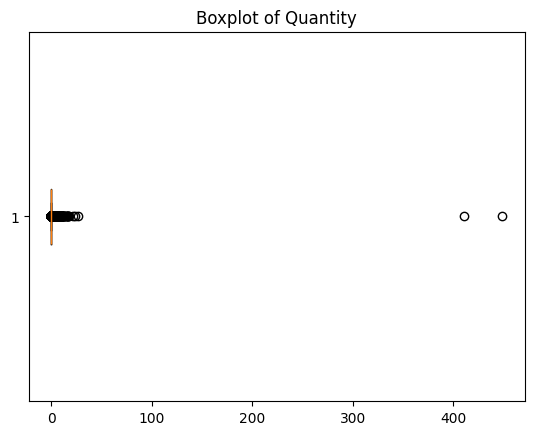

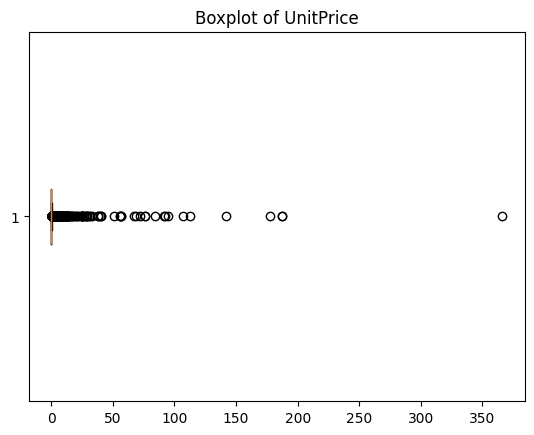

In [11]:
import matplotlib.pyplot as plt

plt.boxplot(df['Quantity'], vert=False)
plt.title("Boxplot of Quantity")
plt.show()

plt.boxplot(df['UnitPrice'], vert=False)
plt.title("Boxplot of UnitPrice")
plt.show()

Outliers are retained because they reflect real bulk and premium purchases, and removing them would reduce business value and bias segmentation results.

In [12]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   InvoiceNo        392692 non-null  object 
 1   StockCode        392692 non-null  object 
 2   Description      392692 non-null  object 
 3   Quantity         392692 non-null  float64
 4   InvoiceDate      392692 non-null  object 
 5   UnitPrice        392692 non-null  float64
 6   CustomerID       392692 non-null  float64
 7   Country          392692 non-null  object 
 8   Country_Encoded  392692 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 30.0+ MB


# Step 2: Feature Engineering
We need to reload the original data to create customer-centric features before applying clustering.

In [13]:
# RELOAD ORIGINAL DATA for feature engineering (unscaled values!)
# The previous df has scaled Quantity/UnitPrice which gives wrong TotalAmount
df_original = pd.read_csv(r"c:\Users\Hajira Ayath\OneDrive\Desktop\Customerprj\customer_data (1).csv", encoding="latin1")

# Apply same cleaning steps
df_original.dropna(subset=["CustomerID"], inplace=True)
df_original['Description'] = df_original['Description'].fillna('Unknown')
df_original = df_original[~df_original['InvoiceNo'].astype(str).str.startswith('C')]
df_original = df_original[df_original['Quantity'] > 0]
df_original = df_original[df_original['UnitPrice'] > 0]
df_original = df_original.drop_duplicates()

# Now calculate TotalAmount with ORIGINAL unscaled values
df_original['InvoiceDate'] = pd.to_datetime(df_original['InvoiceDate'])
df_original['TotalAmount'] = df_original['Quantity'] * df_original['UnitPrice']

print(f"Dataset ready for feature engineering: {df_original.shape}")
print(f"Sample TotalAmount values: {df_original['TotalAmount'].head().tolist()}")

Dataset ready for feature engineering: (392692, 9)
Sample TotalAmount values: [15.299999999999999, 20.34, 22.0, 20.34, 20.34]


In [14]:
# Create customer-centric features
import numpy as np

# Get the maximum date in the dataset to calculate recency
snapshot_date = df_original['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by CustomerID and create aggregated features
customer_features = df_original.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',  # Purchase Frequency (number of unique invoices)
    'TotalAmount': ['sum', 'mean'],  # Customer Lifetime Value and Average Transaction Value
    'InvoiceDate': 'max',  # Last purchase date for recency
    'StockCode': 'nunique',  # Number of unique products purchased
    'Quantity': 'sum'  # Total quantity purchased
}).reset_index()

# Flatten column names
customer_features.columns = ['CustomerID', 'PurchaseFrequency', 'CustomerLifetimeValue', 
                              'AverageTransactionValue', 'LastPurchaseDate', 
                              'UniqueProducts', 'TotalQuantity']

# Calculate Recency (days since last purchase)
customer_features['Recency'] = (snapshot_date - customer_features['LastPurchaseDate']).dt.days

# Drop the LastPurchaseDate column as we now have Recency
customer_features = customer_features.drop('LastPurchaseDate', axis=1)

print(f"Customer features shape: {customer_features.shape}")
customer_features.head()

Customer features shape: (4338, 7)


,CustomerID,PurchaseFrequency,CustomerLifetimeValue,AverageTransactionValue,UniqueProducts,TotalQuantity,Recency
0,12346.0,1,77183.60,77183.600000,1,74215,326
1,12347.0,7,4310.00,23.681319,103,2458,2
2,12348.0,4,1797.24,57.975484,22,2341,75
3,12349.0,1,1757.55,24.076027,73,631,19
4,12350.0,1,334.40,19.670588,17,197,310


In [15]:
# Create rolling average for purchase amounts to capture unusual patterns
# Sort transactions by customer and date
df_sorted = df_original.sort_values(['CustomerID', 'InvoiceDate'])

# Calculate rolling average of transaction amounts (window of 3 transactions)
df_sorted['RollingAvgAmount'] = df_sorted.groupby('CustomerID')['TotalAmount'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Calculate rolling average per customer
rolling_features = df_sorted.groupby('CustomerID').agg({
    'RollingAvgAmount': 'mean'
}).reset_index()

rolling_features.columns = ['CustomerID', 'AvgRollingAmount']

# Merge with customer features
customer_features = customer_features.merge(rolling_features, on='CustomerID', how='left')

print(f"Features after adding rolling average: {customer_features.shape}")
customer_features.head()

Features after adding rolling average: (4338, 8)


,CustomerID,PurchaseFrequency,CustomerLifetimeValue,AverageTransactionValue,UniqueProducts,TotalQuantity,Recency,AvgRollingAmount
0,12346.0,1,77183.60,77183.600000,1,74215,326,77183.600000
1,12347.0,7,4310.00,23.681319,103,2458,2,23.766117
2,12348.0,4,1797.24,57.975484,22,2341,75,57.102366
3,12349.0,1,1757.55,24.076027,73,631,19,21.402283
4,12350.0,1,334.40,19.670588,17,197,310,19.870588


In [16]:
# Display descriptive statistics of features
customer_features.describe()

,CustomerID,PurchaseFrequency,CustomerLifetimeValue,AverageTransactionValue,UniqueProducts,TotalQuantity,Recency,AvgRollingAmount
count,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,4.272015,2048.688081,68.381590,61.501153,1187.644537,92.536422,59.114554
std,1721.808492,7.697998,8985.230220,1467.918294,85.366768,5043.619654,100.014169,1223.749366
min,12346.000000,1.000000,3.750000,2.136970,1.000000,1.000000,1.000000,2.021187
25%,13813.250000,1.000000,306.482500,12.393196,16.000000,159.000000,18.000000,12.213732
50%,15299.500000,2.000000,668.570000,17.755000,35.000000,378.000000,51.000000,17.709805
75%,16778.750000,5.000000,1660.597500,24.878950,77.000000,989.750000,142.000000,24.703106
max,18287.000000,209.000000,280206.020000,77183.600000,1787.000000,196915.000000,374.000000,77183.600000


In [17]:
# Feature Scaling - Standardize all numerical features
from sklearn.preprocessing import StandardScaler

# Select features for clustering (exclude CustomerID)
features_for_clustering = ['PurchaseFrequency', 'CustomerLifetimeValue', 'AverageTransactionValue', 
                           'UniqueProducts', 'TotalQuantity', 'Recency', 'AvgRollingAmount']

# Create a copy for scaling
X = customer_features[features_for_clustering].copy()

# Handle any missing values that might have appeared
X = X.fillna(X.mean())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for better readability
X_scaled_df = pd.DataFrame(X_scaled, columns=features_for_clustering)

print(f"Scaled features shape: {X_scaled_df.shape}")
print("\nScaled features statistics:")
X_scaled_df.describe()

Scaled features shape: (4338, 7)

Scaled features statistics:


,PurchaseFrequency,CustomerLifetimeValue,AverageTransactionValue,UniqueProducts,TotalQuantity,Recency,AvgRollingAmount
count,4.338000e+03,4.338000e+03,4.338000e+03,4.338000e+03,4.338000e+03,4.338000e+03,4.338000e+03
mean,1.801745e-17,2.293130e-17,1.023719e-17,-1.801745e-17,2.784515e-17,2.702618e-17,-3.275900e-18
std,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00
min,-4.250965e-01,-2.276151e-01,-4.513348e-02,-7.088019e-01,-2.353035e-01,-9.153401e-01,-4.665984e-02
25%,-4.250965e-01,-1.939190e-01,-3.814575e-02,-5.330692e-01,-2.039732e-01,-7.453445e-01,-3.832993e-02
50%,-2.951776e-01,-1.536162e-01,-3.449267e-02,-3.104745e-01,-1.605470e-01,-4.153533e-01,-3.383824e-02
75%,9.457903e-02,-4.319704e-02,-2.963902e-02,1.815769e-01,-3.924113e-02,4.946227e-01,-2.812293e-02
max,2.659803e+01,3.096074e+01,5.253978e+01,2.021510e+01,3.881140e+01,2.814561e+00,6.303037e+01


Original features: 7
PCA components: 5

Explained variance ratio: [0.4281144  0.27881191 0.13807928 0.09441199 0.03993399]
Cumulative explained variance: [0.4281144  0.70692631 0.84500559 0.93941758 0.97935157]


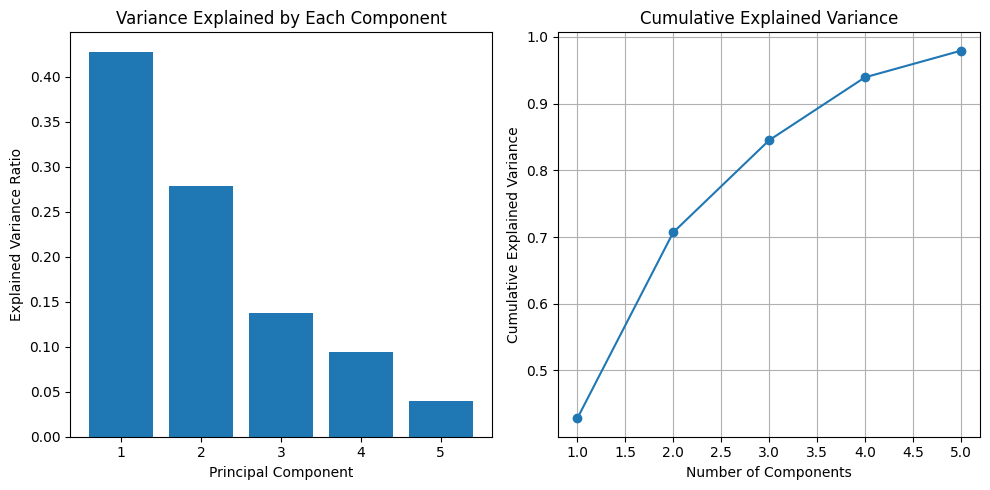

In [18]:
# Dimensionality Reduction using PCA (Principal Component Analysis)
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

print(f"Original features: {X_scaled.shape[1]}")
print(f"PCA components: {X_pca.shape[1]}")
print(f"\nExplained variance ratio: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.cumsum(pca.explained_variance_ratio_)}")

# Visualize explained variance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Variance Explained by Each Component')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Save features for Step 2
customer_features.to_csv("customer_features_step2.csv", index=False)
print("Feature engineering completed and saved!")

Feature engineering completed and saved!


# Step 3: Customer Segmentation using K-Means Clustering

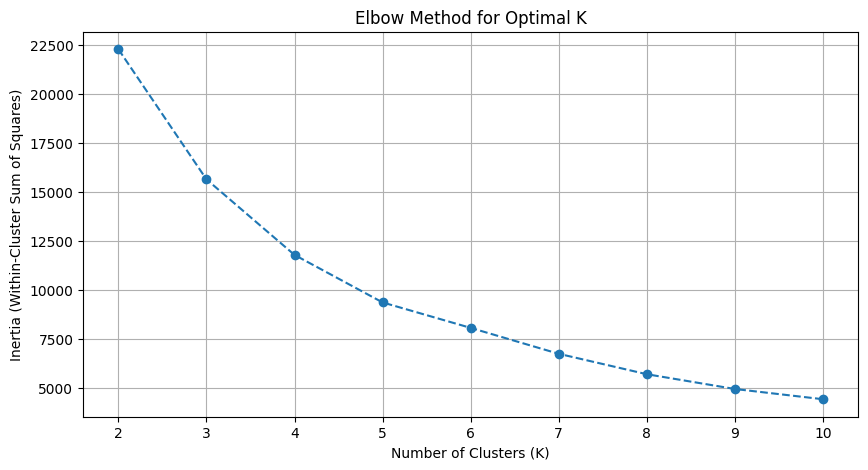

Inertia values for different K:
K=2: Inertia=22299.21
K=3: Inertia=15646.14
K=4: Inertia=11781.53
K=5: Inertia=9352.50
K=6: Inertia=8051.02
K=7: Inertia=6726.21
K=8: Inertia=5682.05
K=9: Inertia=4926.54
K=10: Inertia=4403.45


In [20]:
# Elbow Method to find optimal number of clusters
from sklearn.cluster import KMeans

# Calculate inertia for different values of K
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(10, 5))
plt.plot(K_range, inertias, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.xticks(K_range)
plt.grid(True)
plt.show()

print("Inertia values for different K:")
for k, inertia in zip(K_range, inertias):
    print(f"K={k}: Inertia={inertia:.2f}")

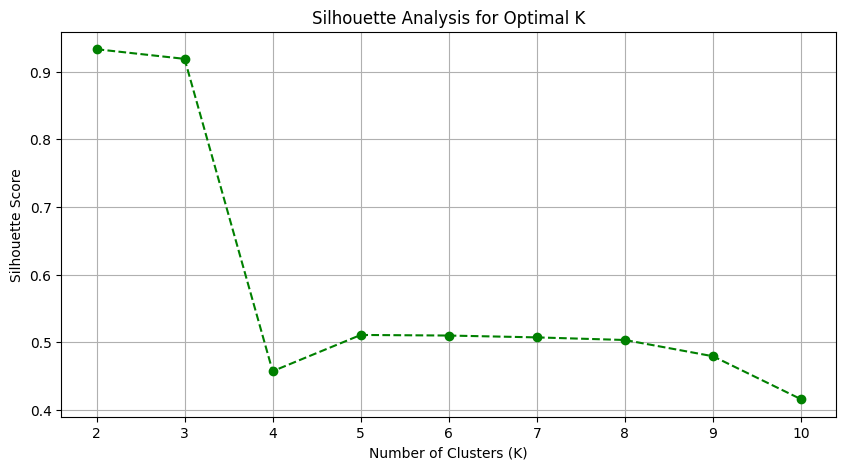


Silhouette scores for different K:
K=2: Silhouette Score=0.9332
K=3: Silhouette Score=0.9189
K=4: Silhouette Score=0.4572
K=5: Silhouette Score=0.5108
K=6: Silhouette Score=0.5100
K=7: Silhouette Score=0.5072
K=8: Silhouette Score=0.5034
K=9: Silhouette Score=0.4793
K=10: Silhouette Score=0.4158

Optimal K based on Silhouette Score: 2


In [21]:
# Silhouette Analysis to validate optimal K
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='--', color='green')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal K')
plt.xticks(K_range)
plt.grid(True)
plt.show()

print("\nSilhouette scores for different K:")
for k, score in zip(K_range, silhouette_scores):
    print(f"K={k}: Silhouette Score={score:.4f}")
    
optimal_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\nOptimal K based on Silhouette Score: {optimal_k}")

K-Means clustering completed with K=4

Cluster distribution:
Cluster
0    3177
1    1143
2       2
3      16
Name: count, dtype: int64


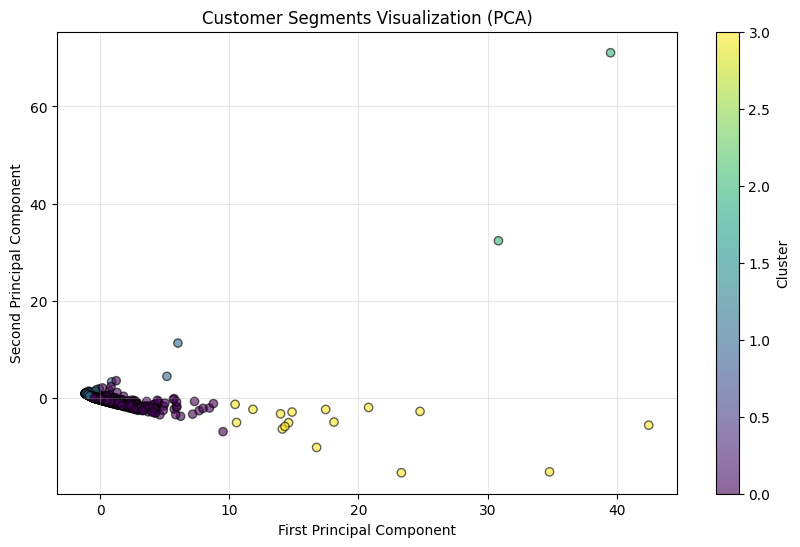

In [22]:
# Apply K-Means with 4 clusters
optimal_k = 4

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_features['Cluster'] = kmeans_final.fit_predict(X_scaled)

print(f"K-Means clustering completed with K={optimal_k}")
print(f"\nCluster distribution:")
print(customer_features['Cluster'].value_counts().sort_index())

# Visualize clusters using first two principal components
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=customer_features['Cluster'], 
                     cmap='viridis', 
                     alpha=0.6, 
                     edgecolors='black')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Customer Segments Visualization (PCA)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

# Step 4: Cluster Analysis & Evaluation

In [23]:
# Evaluate clustering quality using multiple metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

silhouette = silhouette_score(X_scaled, customer_features['Cluster'])
davies_bouldin = davies_bouldin_score(X_scaled, customer_features['Cluster'])
calinski_harabasz = calinski_harabasz_score(X_scaled, customer_features['Cluster'])

print("=" * 60)
print("CLUSTERING EVALUATION METRICS")
print("=" * 60)
print(f"Silhouette Score: {silhouette:.4f}")
print(f"  → Range: [-1, 1], Higher is better (>0.5 is good)")
print(f"\nDavies-Bouldin Index: {davies_bouldin:.4f}")
print(f"  → Lower is better (closer to 0)")
print(f"\nCalinski-Harabasz Index: {calinski_harabasz:.4f}")
print(f"  → Higher is better")
print("=" * 60)

CLUSTERING EVALUATION METRICS
Silhouette Score: 0.4572
  → Range: [-1, 1], Higher is better (>0.5 is good)

Davies-Bouldin Index: 0.7259
  → Lower is better (closer to 0)

Calinski-Harabasz Index: 2278.8535
  → Higher is better


In [24]:
# Profile each cluster - analyze characteristics
cluster_profiles = customer_features.groupby('Cluster').agg({
    'PurchaseFrequency': ['mean', 'median'],
    'CustomerLifetimeValue': ['mean', 'median'],
    'AverageTransactionValue': ['mean', 'median'],
    'UniqueProducts': ['mean', 'median'],
    'TotalQuantity': ['mean', 'median'],
    'Recency': ['mean', 'median'],
    'AvgRollingAmount': ['mean', 'median']
}).round(2)

print("\nCLUSTER PROFILES:")
print("=" * 100)
print(cluster_profiles)
print("=" * 100)


CLUSTER PROFILES:
        PurchaseFrequency        CustomerLifetimeValue             \
                     mean median                  mean     median   
Cluster                                                             
0                    4.89    3.0               1978.64     946.64   
1                    1.56    1.0                544.23     309.52   
2                    1.50    1.5             122828.05  122828.05   
3                   75.62   57.5             108334.76   73752.20   

        AverageTransactionValue           UniqueProducts        TotalQuantity  \
                           mean    median           mean median          mean   
Cluster                                                                         
0                         31.38     17.70          71.89   48.0       1170.42   
1                         53.47     17.82          23.80   17.0        281.51   
2                      66670.55  66670.55           2.00    2.0      77606.00   
3          

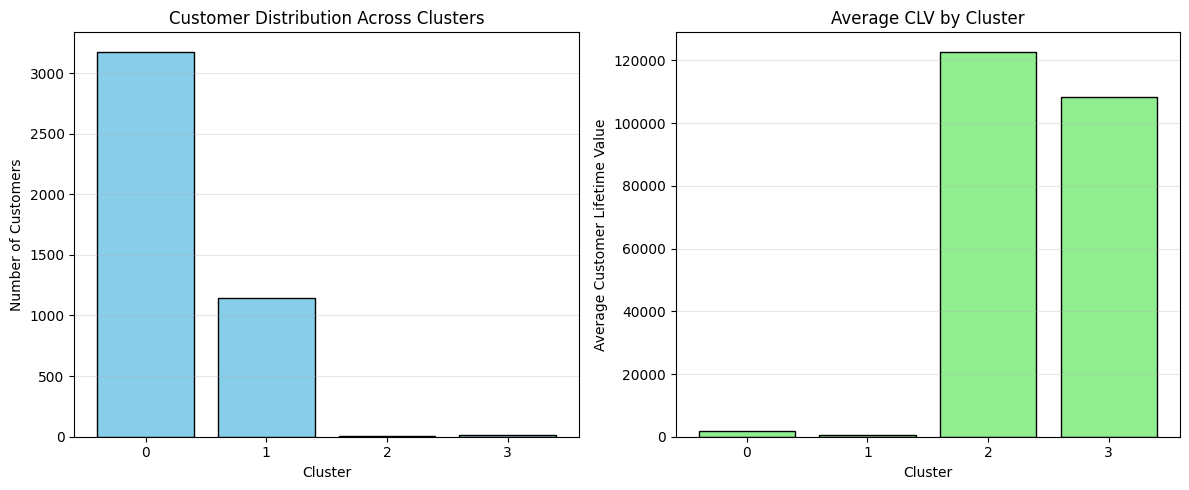

In [25]:
# Create cluster size visualization
plt.figure(figsize=(12, 5))

# Cluster distribution
plt.subplot(1, 2, 1)
cluster_counts = customer_features['Cluster'].value_counts().sort_index()
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.title('Customer Distribution Across Clusters')
plt.xticks(cluster_counts.index)
plt.grid(axis='y', alpha=0.3)

# Average CLV by cluster
plt.subplot(1, 2, 2)
avg_clv = customer_features.groupby('Cluster')['CustomerLifetimeValue'].mean()
plt.bar(avg_clv.index, avg_clv.values, color='lightgreen', edgecolor='black')
plt.xlabel('Cluster')
plt.ylabel('Average Customer Lifetime Value')
plt.title('Average CLV by Cluster')
plt.xticks(avg_clv.index)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

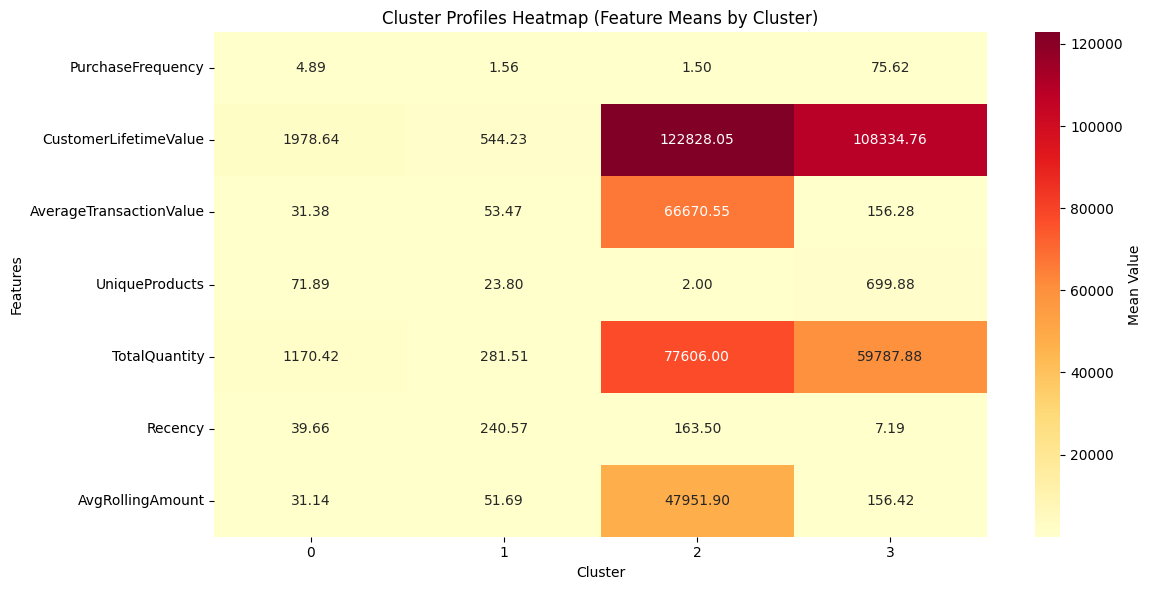

In [26]:
# Create detailed cluster comparison heatmap
import seaborn as sns

# Get mean values for each cluster
cluster_means = customer_features.groupby('Cluster')[features_for_clustering].mean()

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means.T, annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': 'Mean Value'})
plt.title('Cluster Profiles Heatmap (Feature Means by Cluster)')
plt.xlabel('Cluster')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [27]:
# Label clusters with 4 UNIQUE descriptive names based on CLV ranking

# Calculate stats for each cluster
cluster_stats = []
for cluster_id in range(optimal_k):
    cluster_data = customer_features[customer_features['Cluster'] == cluster_id]
    cluster_stats.append({
        'Cluster': cluster_id,
        'AvgCLV': cluster_data['CustomerLifetimeValue'].mean(),
        'AvgFreq': cluster_data['PurchaseFrequency'].mean(),
        'AvgRecency': cluster_data['Recency'].mean(),
        'Size': len(cluster_data)
    })

cluster_stats_df = pd.DataFrame(cluster_stats)
print("Cluster Statistics:")
print(cluster_stats_df)
print()

# Rank clusters by CLV to assign unique labels
cluster_stats_df['CLV_Rank'] = cluster_stats_df['AvgCLV'].rank(ascending=False)

# Assign 4 UNIQUE labels based on CLV ranking
label_map = {}
for _, row in cluster_stats_df.iterrows():
    cluster_id = int(row['Cluster'])
    clv_rank = int(row['CLV_Rank'])
    
    if clv_rank == 1:
        label = "Premium VIP Customers"
    elif clv_rank == 2:
        label = "High-Value Customers"
    elif clv_rank == 3:
        label = "Regular Customers"
    else:
        label = "Budget Customers"
    
    label_map[cluster_id] = label

# Apply labels
customer_features['ClusterLabel'] = customer_features['Cluster'].map(label_map)

# Print results
print("\n" + "=" * 70)
print("FINAL CLUSTER LABELS (Ranked by Customer Lifetime Value):")
print("=" * 70)

for cluster_id in range(optimal_k):
    cluster_data = customer_features[customer_features['Cluster'] == cluster_id]
    label = label_map[cluster_id]
    avg_clv = cluster_data['CustomerLifetimeValue'].mean()
    avg_freq = cluster_data['PurchaseFrequency'].mean()
    size = len(cluster_data)
    
    print(f"\nCluster {cluster_id}: {label}")
    print(f"  - Size: {size} customers")
    print(f"  - Avg CLV: ${avg_clv:,.2f}")
    print(f"  - Avg Purchase Frequency: {avg_freq:.2f}")

print("\n" + "=" * 70)
print("VERIFICATION - All 4 clusters have UNIQUE labels:")
print(customer_features['ClusterLabel'].value_counts())
print("=" * 70)

Cluster Statistics:
   Cluster         AvgCLV    AvgFreq  AvgRecency  Size
0        0    1978.641606   4.890148   39.664463  3177
1        1     544.227621   1.559930  240.566054  1143
2        2  122828.050000   1.500000  163.500000     2
3        3  108334.765000  75.625000    7.187500    16


FINAL CLUSTER LABELS (Ranked by Customer Lifetime Value):

Cluster 0: Regular Customers
  - Size: 3177 customers
  - Avg CLV: $1,978.64
  - Avg Purchase Frequency: 4.89

Cluster 1: Budget Customers
  - Size: 1143 customers
  - Avg CLV: $544.23
  - Avg Purchase Frequency: 1.56

Cluster 2: Premium VIP Customers
  - Size: 2 customers
  - Avg CLV: $122,828.05
  - Avg Purchase Frequency: 1.50

Cluster 3: High-Value Customers
  - Size: 16 customers
  - Avg CLV: $108,334.76
  - Avg Purchase Frequency: 75.62

VERIFICATION - All 4 clusters have UNIQUE labels:
ClusterLabel
Regular Customers        3177
Budget Customers         1143
High-Value Customers       16
Premium VIP Customers       2
Name: count, 

# Step 5: Recommendation System
Build a system to recommend best-selling products within each cluster to customers who haven't purchased them.

In [28]:
# Merge cluster information with original transaction data
df_with_clusters = df_original.merge(
    customer_features[['CustomerID', 'Cluster', 'ClusterLabel']], 
    on='CustomerID', 
    how='left'
)

print(f"Transactions with cluster labels: {df_with_clusters.shape}")
df_with_clusters.head()

Transactions with cluster labels: (392692, 11)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,Cluster,ClusterLabel
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,1,Budget Customers
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,1,Budget Customers
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,1,Budget Customers
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,1,Budget Customers
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,1,Budget Customers


In [29]:
# Find top-selling products in each cluster
def get_top_products_by_cluster(df, cluster_id, top_n=10):
    """Get top N products for a specific cluster based on total quantity sold"""
    cluster_data = df[df['Cluster'] == cluster_id]
    
    # Calculate product popularity (total quantity * frequency)
    product_stats = cluster_data.groupby(['StockCode', 'Description']).agg({
        'Quantity': 'sum',
        'CustomerID': 'nunique',
        'TotalAmount': 'sum'
    }).reset_index()
    
    product_stats.columns = ['StockCode', 'Description', 'TotalQuantity', 'UniqueCustomers', 'TotalRevenue']
    
    # Sort by total revenue (best indicator of popularity)
    product_stats = product_stats.sort_values('TotalRevenue', ascending=False)
    
    return product_stats.head(top_n)

# Get top products for each cluster
print("TOP 10 PRODUCTS BY CLUSTER:")
print("=" * 100)

top_products_by_cluster = {}
for cluster_id in range(optimal_k):
    print(f"\nCluster {cluster_id} - {customer_features[customer_features['Cluster']==cluster_id]['ClusterLabel'].iloc[0]}:")
    top_products = get_top_products_by_cluster(df_with_clusters, cluster_id, top_n=10)
    top_products_by_cluster[cluster_id] = top_products
    print(top_products[['StockCode', 'Description', 'TotalQuantity', 'UniqueCustomers', 'TotalRevenue']].to_string(index=False))
    print("-" * 100)

TOP 10 PRODUCTS BY CLUSTER:

Cluster 0 - Regular Customers:
StockCode                        Description  TotalQuantity  UniqueCustomers  TotalRevenue
    22423           REGENCY CAKESTAND 3 TIER           9732              701     111834.10
   85099B            JUMBO BAG RED RETROSPOT          35657              556      66687.50
   85123A WHITE HANGING HEART T-LIGHT HOLDER          23582              673      63721.30
     POST                            POSTAGE           2828              262      62282.31
    47566                      PARTY BUNTING          12382              565      55871.60
    84879      ASSORTED COLOUR BIRD ORNAMENT          31058              566      49702.10
        M                             Manual           6528              170      47155.40
    23084                 RABBIT NIGHT LIGHT          20309              436      37339.99
    22086    PAPER CHAIN KIT 50'S CHRISTMAS           13719              571      37167.85
    21137           BLACK RECO

In [30]:
# Create recommendation function
def generate_recommendations(customer_id, df_transactions, customer_features, top_products_dict, n_recommendations=5):
    """
    Generate product recommendations for a customer based on their cluster
    Recommends top-selling products in their cluster that they haven't purchased
    """
    # Get customer's cluster
    customer_cluster = customer_features[customer_features['CustomerID'] == customer_id]['Cluster'].values
    
    if len(customer_cluster) == 0:
        return pd.DataFrame()  # Customer not found
    
    customer_cluster = customer_cluster[0]
    
    # Get products customer has already purchased
    purchased_products = df_transactions[df_transactions['CustomerID'] == customer_id]['StockCode'].unique()
    
    # Get top products in the cluster
    cluster_top_products = top_products_dict[customer_cluster]
    
    # Filter out products already purchased
    recommendations = cluster_top_products[~cluster_top_products['StockCode'].isin(purchased_products)]
    
    return recommendations.head(n_recommendations)[['StockCode', 'Description', 'TotalRevenue', 'UniqueCustomers']]

# Test recommendation system with a few customers
print("SAMPLE RECOMMENDATIONS:")
print("=" * 100)

sample_customers = customer_features['CustomerID'].head(5).values

for customer_id in sample_customers:
    cluster = customer_features[customer_features['CustomerID'] == customer_id]['Cluster'].values[0]
    cluster_label = customer_features[customer_features['CustomerID'] == customer_id]['ClusterLabel'].values[0]
    
    print(f"\nCustomer ID: {customer_id}")
    print(f"Cluster: {cluster} - {cluster_label}")
    print("\nRecommended Products:")
    
    recommendations = generate_recommendations(customer_id, df_with_clusters, customer_features, top_products_by_cluster)
    
    if len(recommendations) > 0:
        print(recommendations.to_string(index=False))
    else:
        print("No new recommendations (customer purchased all top products)")
    
    print("-" * 100)

SAMPLE RECOMMENDATIONS:

Customer ID: 12346.0
Cluster: 2 - Premium VIP Customers

Recommended Products:
StockCode                 Description  TotalRevenue  UniqueCustomers
    23843 PAPER CRAFT , LITTLE BIRDIE     168469.60                1
    22980      PANTRY SCRUBBING BRUSH          1.65                1
    22982         PANTRY PASTRY BRUSH          1.25                1
----------------------------------------------------------------------------------------------------

Customer ID: 12347.0
Cluster: 0 - Regular Customers

Recommended Products:
StockCode                        Description  TotalRevenue  UniqueCustomers
   85099B            JUMBO BAG RED RETROSPOT      66687.50              556
   85123A WHITE HANGING HEART T-LIGHT HOLDER      63721.30              673
     POST                            POSTAGE      62282.31              262
    47566                      PARTY BUNTING      55871.60              565
    84879      ASSORTED COLOUR BIRD ORNAMENT      49702.10     

In [31]:
# Generate recommendations for ALL customers
all_recommendations = []

for customer_id in customer_features['CustomerID']:
    cluster = customer_features[customer_features['CustomerID'] == customer_id]['Cluster'].values[0]
    recommendations = generate_recommendations(customer_id, df_with_clusters, customer_features, top_products_by_cluster, n_recommendations=5)
    
    if len(recommendations) > 0:
        recommendations['CustomerID'] = customer_id
        recommendations['Cluster'] = cluster
        all_recommendations.append(recommendations)

# Combine all recommendations
recommendations_df = pd.concat(all_recommendations, ignore_index=True)

print(f"Total recommendations generated: {len(recommendations_df)}")
print(f"Customers with recommendations: {recommendations_df['CustomerID'].nunique()}")
print("\nSample recommendations:")
recommendations_df.head(10)

Total recommendations generated: 21612
Customers with recommendations: 4338

Sample recommendations:


,StockCode,Description,TotalRevenue,UniqueCustomers,CustomerID,Cluster
0,23843,"PAPER CRAFT , LITTLE BIRDIE",168469.60,1,12346.0,2
1,22980,PANTRY SCRUBBING BRUSH,1.65,1,12346.0,2
2,22982,PANTRY PASTRY BRUSH,1.25,1,12346.0,2
3,85099B,JUMBO BAG RED RETROSPOT,66687.50,556,12347.0,0
4,85123A,WHITE HANGING HEART T-LIGHT HOLDER,63721.30,673,12347.0,0
5,POST,POSTAGE,62282.31,262,12347.0,0
6,47566,PARTY BUNTING,55871.60,565,12347.0,0
7,84879,ASSORTED COLOUR BIRD ORNAMENT,49702.10,566,12347.0,0
8,22423,REGENCY CAKESTAND 3 TIER,111834.10,701,12348.0,0
9,85099B,JUMBO BAG RED RETROSPOT,66687.50,556,12348.0,0


# Save Final Outputs for Dashboard (Step 6)

In [32]:
# Export customer segments with cluster labels
customer_segments = customer_features[['CustomerID', 'Cluster', 'ClusterLabel', 'PurchaseFrequency', 
                                       'CustomerLifetimeValue', 'AverageTransactionValue', 
                                       'UniqueProducts', 'Recency']].copy()

customer_segments.to_csv("customer_segments_final.csv", index=False)
print("✓ Saved: customer_segments_final.csv")

# Export recommendations
recommendations_export = recommendations_df[['CustomerID', 'Cluster', 'StockCode', 'Description', 'TotalRevenue']].copy()
recommendations_export.columns = ['CustomerID', 'Cluster', 'ProductCode', 'ProductDescription', 'EstimatedRevenue']
recommendations_export.to_csv("product_recommendations.csv", index=False)
print("✓ Saved: product_recommendations.csv")

# Export cluster profiles for analysis
cluster_profiles_export = customer_features.groupby('Cluster').agg({
    'CustomerID': 'count',
    'ClusterLabel': 'first',
    'PurchaseFrequency': 'mean',
    'CustomerLifetimeValue': 'mean',
    'AverageTransactionValue': 'mean',
    'UniqueProducts': 'mean',
    'Recency': 'mean'
}).round(2)

cluster_profiles_export.columns = ['TotalCustomers', 'ClusterName', 'AvgPurchaseFrequency', 
                                    'AvgLifetimeValue', 'AvgTransactionValue', 
                                    'AvgUniqueProducts', 'AvgRecency']

cluster_profiles_export.to_csv("cluster_profiles.csv")
print("✓ Saved: cluster_profiles.csv")

# Export top products by cluster
for cluster_id in range(optimal_k):
    top_prods = top_products_by_cluster[cluster_id].copy()
    top_prods.to_csv(f"top_products_cluster_{cluster_id}.csv", index=False)
    print(f"✓ Saved: top_products_cluster_{cluster_id}.csv")

print("ALL DATA EXPORTS COMPLETED!")
print("=" * 60)

✓ Saved: customer_segments_final.csv
✓ Saved: product_recommendations.csv
✓ Saved: cluster_profiles.csv
✓ Saved: top_products_cluster_0.csv
✓ Saved: top_products_cluster_1.csv
✓ Saved: top_products_cluster_2.csv
✓ Saved: top_products_cluster_3.csv
ALL DATA EXPORTS COMPLETED!


In [33]:
# Correct way to check your cluster counts
print(customer_segments['ClusterLabel'].value_counts())

ClusterLabel
Regular Customers        3177
Budget Customers         1143
High-Value Customers       16
Premium VIP Customers       2
Name: count, dtype: int64
